In [ ]:
#reference: https://mochisoft.medium.com/malaria-parasite-detection-using-convolutional-neural-networks-case-study-in-jovian-ai-course-390b543c35a

In [30]:
import opendatasets as od

In [31]:
dataset_url = 'https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria/download'
od.download(dataset_url)

In [1]:
#we import pre-requisite python libraries in the code section below
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision import datasets, transforms

%matplotlib inline

In [2]:
DATA_DIR = 'C:\\Users\\ASUS\Desktop\\malaria\\cell_images\\'
POS_DIR = DATA_DIR + '\\Parasitized'
NEG_DIR = DATA_DIR + '\\Uninfected'

In [3]:
#Transformation of images to PyTorch Tensor dataset
transform = transforms.Compose([transforms.Resize((108,108)),
        transforms.Pad(2),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

In [4]:
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

In [36]:
dataset.classes

['Parasitized', 'Uninfected']

In [37]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 112, 112])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label (numeric): 0


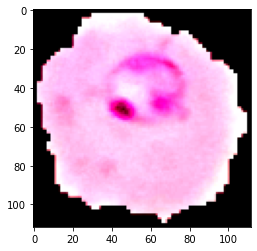

In [38]:
#The resulting images shape after transformation becomes (3,112,112) and below, we can view sample image from the dataset.
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
#print('Label (textual):', classes[label])

In [39]:
#Dataset preparation for training
random_seed = 43
torch.manual_seed(random_seed)
val_size = 5000
test_size = 1000
train_size = len(dataset) - val_size -test_size

In [40]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(21558, 5000, 1000)

In [41]:
batch_size=128

In [42]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 3, 112, 112])


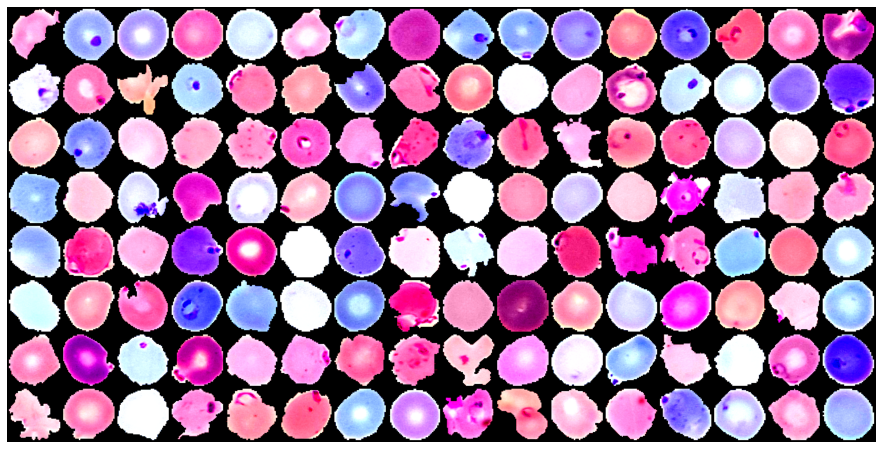

In [44]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [45]:
#Base model class and training on GPU
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

        

In [47]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [48]:
#we define MalariaCNNModel class using the nn.Sequential class to chain the layers and activation functions into a single network architecture.
class MalariaCNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), #16 X 112 X 112
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), #32 112 112
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 56 x 56

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), #64 X 56 X 56
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 28 x 28

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 14 x 14

            nn.Flatten(), 
            nn.Linear(128*14*14, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [49]:
model = MalariaCNNModel()
model

MalariaCNNModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=25088, out_features=120, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [50]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [52]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [57]:
device = get_default_device()
device

device(type='cpu')

In [58]:
#Loading data to device
#We define, DeviceDataLoader class for use in loading the model for execution in the default device.
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [59]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [60]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [61]:
#We move our training and validation data loaders to available device.
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [62]:
#Training the model
model = to_device(MalariaCNNModel(), device)

In [64]:
evaluate(model,val_loader)

{'val_loss': 0.694574236869812, 'val_acc': 0.5133272409439087}

In [65]:
#We set model parameters and log the parameters using jovian.log_hyperparams. We will review the params three times in order to identify optimal settings.
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [66]:
#we train the model using the hyper_params and below we display the validation_loss and validtion_accuracy based on the used parameters.
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], val_loss: 0.1571, val_acc: 0.9546
Epoch [1], val_loss: 0.1730, val_acc: 0.9535
Epoch [2], val_loss: 0.1298, val_acc: 0.9579
Epoch [3], val_loss: 0.1452, val_acc: 0.9567
Epoch [4], val_loss: 0.1300, val_acc: 0.9579
Epoch [5], val_loss: 0.1231, val_acc: 0.9589
Epoch [6], val_loss: 0.1128, val_acc: 0.9602
Epoch [7], val_loss: 0.1255, val_acc: 0.9606
Epoch [8], val_loss: 0.1180, val_acc: 0.9622
Epoch [9], val_loss: 0.1163, val_acc: 0.9632


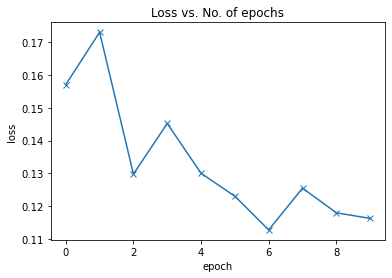

In [67]:
#Loss vs Number of epochs graph
plot_losses(history)

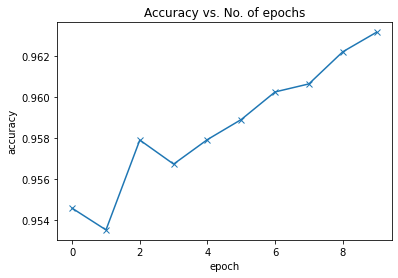

In [68]:
#Accuracy vs number of epochs graph
plot_accuracies(history)

In [69]:
#Testing the model
#Finally, we test the model using test data and randomly select three images from the dataset for displaying the predicted results from the model
test_loader = DeviceDataLoader(test_loader, device)

In [70]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Uninfected , Predicted: Uninfected


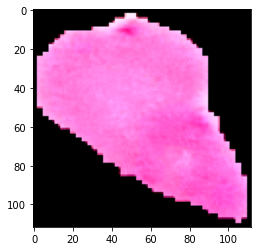

In [71]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Parasitized , Predicted: Parasitized


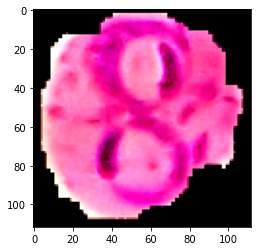

In [72]:
img, label = test_ds[110]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Parasitized , Predicted: Parasitized


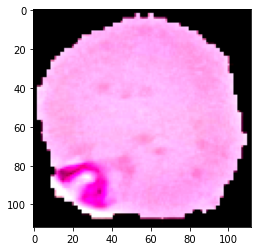

In [73]:
img, label = test_ds[857]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [74]:
result = evaluate(model, test_loader)
result

{'val_loss': 0.12768243253231049, 'val_acc': 0.9509361386299133}